# MULTIVARIATE LSTM SINGLE STEP

In [84]:
import tensorflow as tf
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [85]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.4.1
Pandas Version: 1.1.3
Numpy Version: 1.19.2
System Version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [86]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [90]:
import pandas as pd
import numpy as np

data = pd.read_csv('df_north.csv')
#df = xl.parse('Sheet1')
# данные для однопараметрической модели - Univariate
data.head()
uni_data = data['AKSH_218_liq_vol']
uni_data.index = data['date']

#data = pd.read_csv('oildatadc.xlsx')

In [91]:
# разметка данных для окна прогнозирования- dataset - Данные, start/end indes

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # размер окна истории для обучения
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [92]:
df = data

In [95]:
uni_data = df['AKSH_218_liq_vol']
uni_data.index = df['date']
uni_data.head()

date
2017-01-01    101.18
2017-01-02    101.57
2017-01-03    109.20
2017-01-04    108.85
2017-01-05    109.02
Name: AKSH_218_liq_vol, dtype: float64

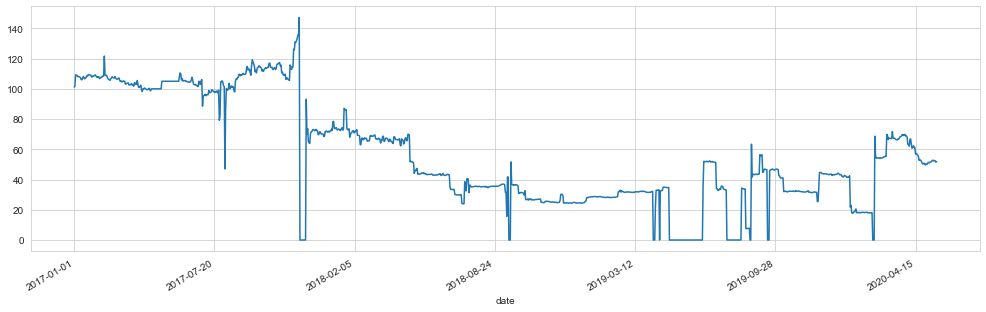

In [96]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [97]:
TRAIN_SPLIT = 400

In [98]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean() # нормализация - важно для LSTM
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [99]:
uni_data = (uni_data-uni_train_mean)/uni_train_std # деление на стандартное отклонение для нормализации

In [100]:
univariate_past_history = 20 # история
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(dataset=uni_data, # данные
                                           start_index=0, # отчёт окна от начала прогозирования назад
                                           end_index=TRAIN_SPLIT, # разбиение
                                           history_size=univariate_past_history, # длина окна
                                           target_size=univariate_future_target) # длина прогноза
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [101]:
def create_time_steps(length):
    return list(range(-length, 0)) # шаги прогозирования

In [102]:
def show_plot(plot_data, delta, title): # отрисовка
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

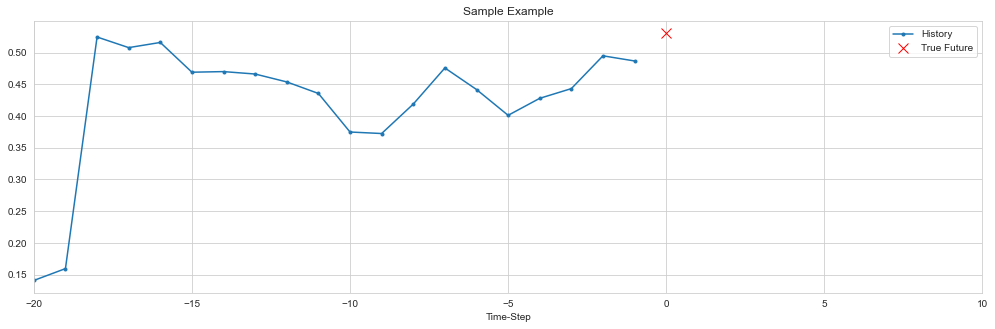

In [103]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [104]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

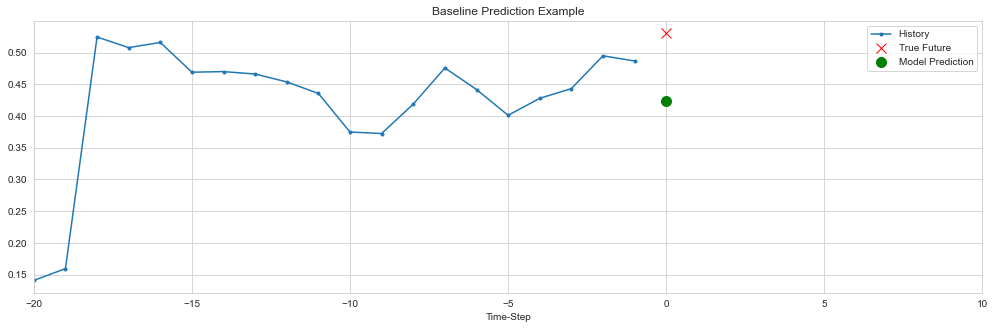

In [105]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [106]:
#Чтобы создать конвейер ввода, вы должны начать с источника данных. Например, чтобы создать Dataset из данных в памяти,
#вы можете использовать tf.data.Dataset.from_tensors() или tf.data.Dataset.from_tensor_slices() . 
#В качестве альтернативы, если ваши входные данные хранятся в файле в рекомендуемом формате TFRecord, 
# вы можете использовать tf.data.TFRecordDataset() .

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [107]:
x_train_uni.shape

(380, 20, 1)

In [108]:
# архитектура сети

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [109]:
# размерность кна предсказания

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [110]:
rng = np.random.RandomState(1)

In [111]:
# Earlystopping для предотвразения возможного переобучения модели

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 3s 10ms/step - loss: 0.4489 - val_loss: 1.6134
Epoch 2/4
200/200 [==============================] - 2s 8ms/step - loss: 0.2364 - val_loss: 1.5500
Epoch 3/4
200/200 [==============================] - 2s 8ms/step - loss: 0.2183 - val_loss: 1.4974
Epoch 4/4
200/200 [==============================] - 2s 8ms/step - loss: 0.2100 - val_loss: 1.4265


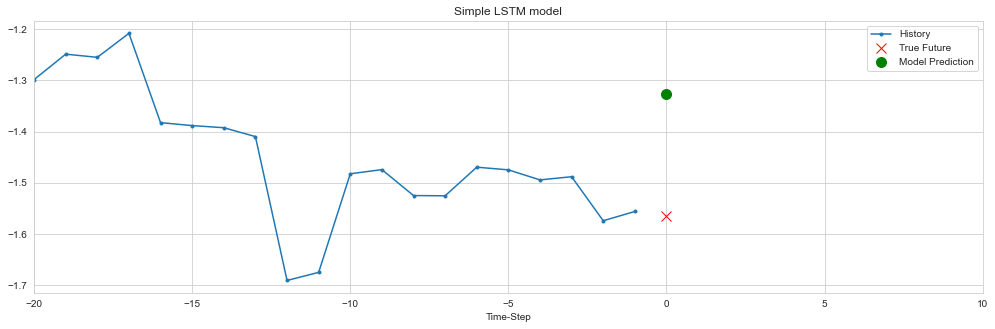

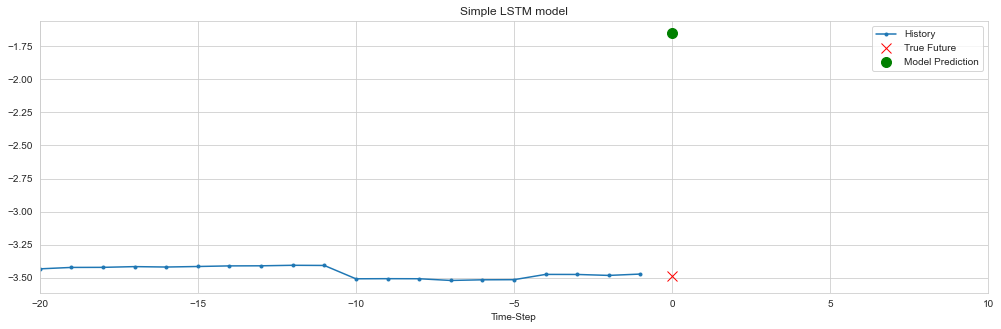

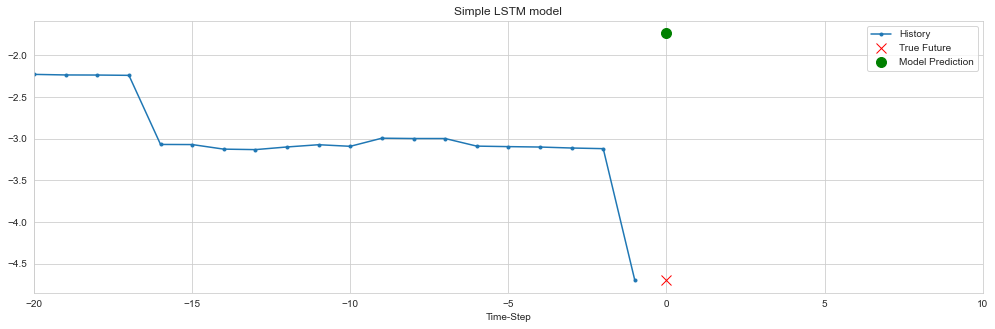

In [112]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [113]:
data.head()

,Unnamed: 0,date,AKSH_227_liq_vol,AKSH_227_wc_vol,AKSH_227_bhp_fluid_level,AKSH_227_bhp_pump_press,AKSH_240_liq_vol,AKSH_240_wc_vol,AKSH_240_bhp_fluid_level,AKSH_240_bhp_pump_press,...,AKSH_225_water_vol,AKSH_225_water_type,AKSH_220_water_vol,AKSH_220_water_type,AKSH_240_water_vol,AKSH_240_water_type,AKSH_217_water_vol,AKSH_217_water_type,AKSH_299_water_vol,AKSH_299_water_type
0,0,2017-01-01,177.07000,90.021,0.0,0.0,NaN,NaN,NaN,NaN,...,213.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,289.0,Артезианская вода,NaN,NaN
1,1,2017-01-02,190.92374,90.014,0.0,0.0,NaN,NaN,NaN,NaN,...,202.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,287.0,Артезианская вода,NaN,NaN
2,2,2017-01-03,168.77000,90.004,0.0,0.0,NaN,NaN,NaN,NaN,...,219.0,Артезианская вода,93.0,Артезианская вода,NaN,NaN,286.0,Артезианская вода,NaN,NaN
3,3,2017-01-04,168.17172,89.975,0.0,0.0,NaN,NaN,NaN,NaN,...,205.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,287.0,Артезианская вода,NaN,NaN
4,4,2017-01-05,168.49000,85.999,0.0,0.0,NaN,NaN,NaN,NaN,...,214.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,286.0,Артезианская вода,NaN,NaN


In [387]:
features_considered = ['AKSH_218_liq_vol', 'AKSH_240_liq_vol','AKSH_227_bhp_pump_press', 'AKSH_240_liq_vol', 'AKSH_240_wc_vol', 'AKSH_240_bhp_fluid_level', 'AKSH_240_bhp_pump_press']

In [115]:
features = data[features_considered]

features.index = data['date']
features.head()

,AKSH_227_wc_vol,AKSH_227_bhp_fluid_level,AKSH_227_bhp_pump_press,AKSH_240_liq_vol,AKSH_240_wc_vol,AKSH_240_bhp_fluid_level,AKSH_240_bhp_pump_press
date,,,,,,,
2017-01-01,90.021,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-02,90.014,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-03,90.004,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-04,89.975,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-05,85.999,0.0,0.0,NaN,NaN,NaN,NaN


In [116]:
#features_considered = dataset.columns.values
print(features_considered) 

['AKSH_227_wc_vol', 'AKSH_227_bhp_fluid_level', 'AKSH_227_bhp_pump_press', 'AKSH_240_liq_vol', 'AKSH_240_wc_vol', 'AKSH_240_bhp_fluid_level', 'AKSH_240_bhp_pump_press']


In [117]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [118]:
TRAIN_SPLIT = 600

In [119]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy import stats
import matplotlib.pyplot as plt

In [120]:
dataset = data

In [121]:
data.head()

,Unnamed: 0,date,AKSH_227_liq_vol,AKSH_227_wc_vol,AKSH_227_bhp_fluid_level,AKSH_227_bhp_pump_press,AKSH_240_liq_vol,AKSH_240_wc_vol,AKSH_240_bhp_fluid_level,AKSH_240_bhp_pump_press,...,AKSH_225_water_vol,AKSH_225_water_type,AKSH_220_water_vol,AKSH_220_water_type,AKSH_240_water_vol,AKSH_240_water_type,AKSH_217_water_vol,AKSH_217_water_type,AKSH_299_water_vol,AKSH_299_water_type
0,0,2017-01-01,177.07000,90.021,0.0,0.0,NaN,NaN,NaN,NaN,...,213.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,289.0,Артезианская вода,NaN,NaN
1,1,2017-01-02,190.92374,90.014,0.0,0.0,NaN,NaN,NaN,NaN,...,202.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,287.0,Артезианская вода,NaN,NaN
2,2,2017-01-03,168.77000,90.004,0.0,0.0,NaN,NaN,NaN,NaN,...,219.0,Артезианская вода,93.0,Артезианская вода,NaN,NaN,286.0,Артезианская вода,NaN,NaN
3,3,2017-01-04,168.17172,89.975,0.0,0.0,NaN,NaN,NaN,NaN,...,205.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,287.0,Артезианская вода,NaN,NaN
4,4,2017-01-05,168.49000,85.999,0.0,0.0,NaN,NaN,NaN,NaN,...,214.0,Артезианская вода,94.0,Артезианская вода,NaN,NaN,286.0,Артезианская вода,NaN,NaN


In [122]:
#data = pd.read_excel('oildatad.xlsx')

In [123]:
#f1 = pd.read_csv('oildata.csv', sep = ",", decimal = '.')

In [124]:
#features_considered = data.columns.values

In [125]:
import tensorflow as tf


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys


mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

In [126]:
#dataset = pd.read_excel('oildatadc.xlsx')

In [127]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [128]:
TRAIN_SPLIT = 400

In [133]:
dataset = features.values
dataset = numpy.nan_to_num(dataset)


In [134]:
print(dataset)

[[90.021  0.     0.    ...  0.     0.     0.   ]
 [90.014  0.     0.    ...  0.     0.     0.   ]
 [90.004  0.     0.    ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]


In [135]:
data_mean = dataset[:TRAIN_SPLIT].mean()
data_std = dataset[:TRAIN_SPLIT].std()

In [136]:
dataset = (dataset-data_mean)/data_std

In [137]:
#dataset = (dataset-data_mean)/data_std

In [138]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [139]:
print(dataset)

[[ 2.82764839 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]
 [ 2.82739535 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]
 [ 2.82703385 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]
 ...
 [-0.42657394 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]
 [-0.42657394 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]
 [-0.42657394 -0.42657394 -0.42657394 ... -0.42657394 -0.42657394
  -0.42657394]]


In [140]:
dataset = numpy.nan_to_num(dataset)

In [141]:
past_history = 15
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [142]:
print(y_train_single)

[-0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0.42657394
 -0.42657394 -0.42657394 -0.42657394 -0.42657394 -0

In [143]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [144]:
#Чтобы создать конвейер ввода, вы должны начать с источника данных. Например, чтобы создать Dataset из данных в памяти,
#вы можете использовать tf.data.Dataset.from_tensors() или tf.data.Dataset.from_tensor_slices() . 
#В качестве альтернативы, если ваши входные данные хранятся в файле в рекомендуемом формате TFRecord, 
# вы можете использовать tf.data.TFRecordDataset() .



train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [145]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

In [146]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [147]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [148]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 18ms/step - loss: 25.1150 - val_loss: 122.1589
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 8.9216 - val_loss: 117.6830
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 7.6427 - val_loss: 111.2283
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 6.6369 - val_loss: 107.4561
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 6.0748 - val_loss: 102.9016
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 5.8772 - val_loss: 99.6851
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 5.5742 - val_loss: 96.7232
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 5.2998 - val_loss: 96.1119
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 5.1025 - val_loss: 97.3878
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 

In [149]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

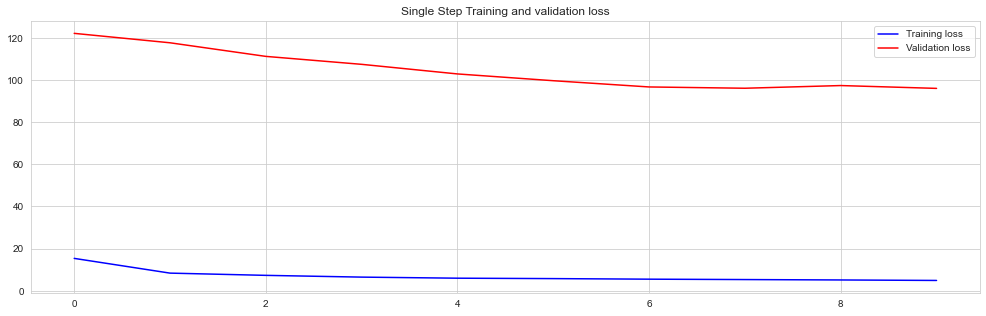

In [150]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [151]:
past_history = 70
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,5], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,5],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [152]:

#Чтобы создать конвейер ввода, вы должны начать с источника данных. Например, чтобы создать Dataset из данных в памяти,
#вы можете использовать tf.data.Dataset.from_tensors() или tf.data.Dataset.from_tensor_slices() . 
#В качестве альтернативы, если ваши входные данные хранятся в файле в рекомендуемом формате TFRecord, 
# вы можете использовать tf.data.TFRecordDataset() .

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [153]:
# простая 32 нейронная 1 шаговая модель с 1 мерным выводом 

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

In [154]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [155]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 14ms/step - loss: 12.9301 - val_loss: 17.7038
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 5.5279 - val_loss: 14.3637
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 4.7250 - val_loss: 9.9779
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 3.6057 - val_loss: 9.6925
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 2.6178 - val_loss: 7.5668
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 2.4932 - val_loss: 8.1096
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 2.3930 - val_loss: 5.6055
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 2.0574 - val_loss: 5.5403
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 2.0702 - val_loss: 5.5578
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 1.8750 - val

In [156]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

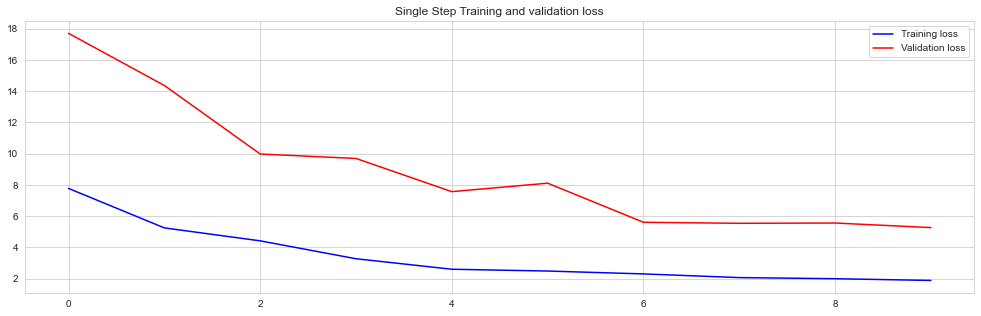

In [157]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [158]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [159]:
import matplotlib.pyplot as plt

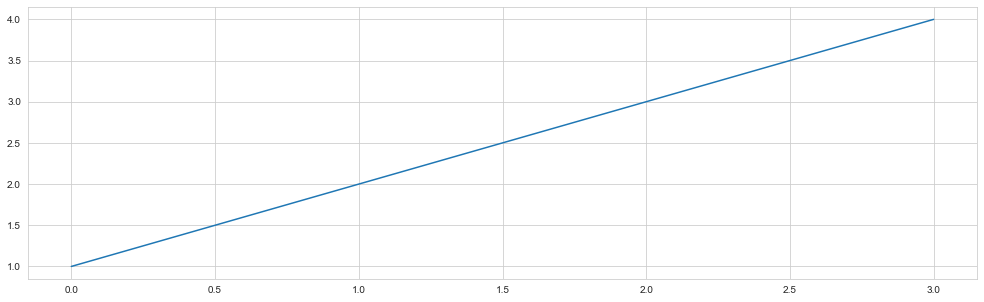

In [160]:
plt.plot([1,2,3,4])

In [161]:
from matplotlib import*



In [162]:
def create_time_steps(length):
    return list(range(-length, 0))

In [163]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

In [164]:
def baseline(history):
    return np.mean(history)

In [165]:
#show_plot([x_train_single[0], y_train_single[0], baseline(x_train_single[0])], 0,
 #          'Baseline Prediction Example')

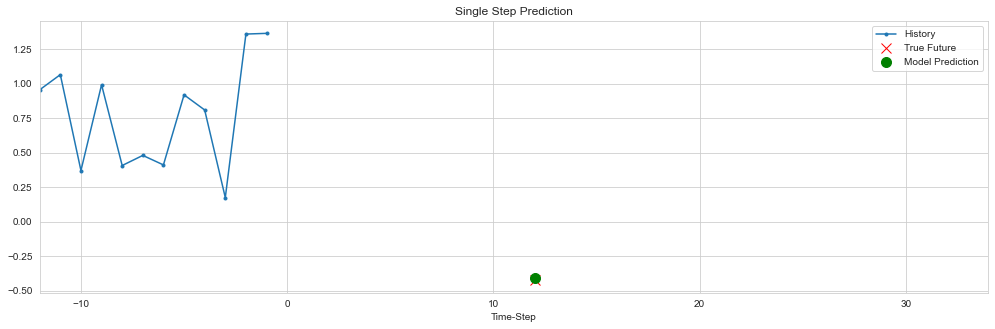

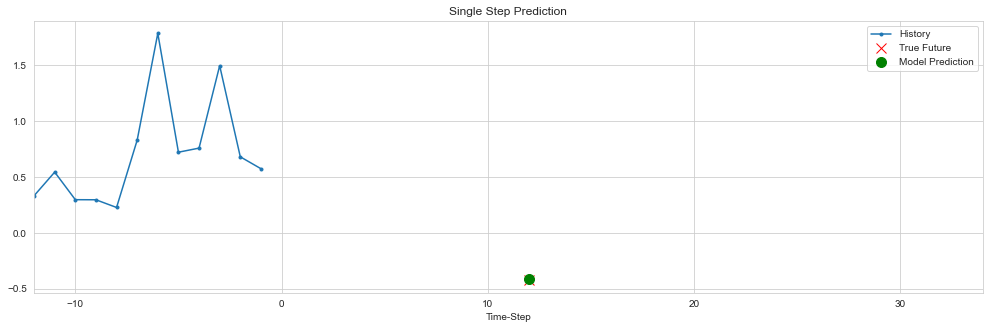

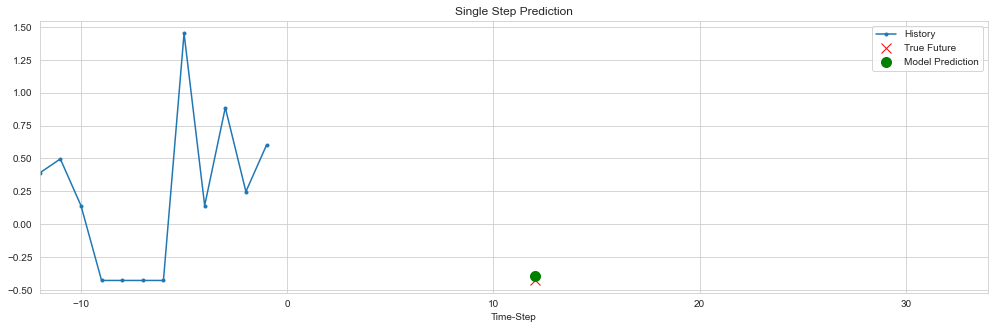

In [166]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

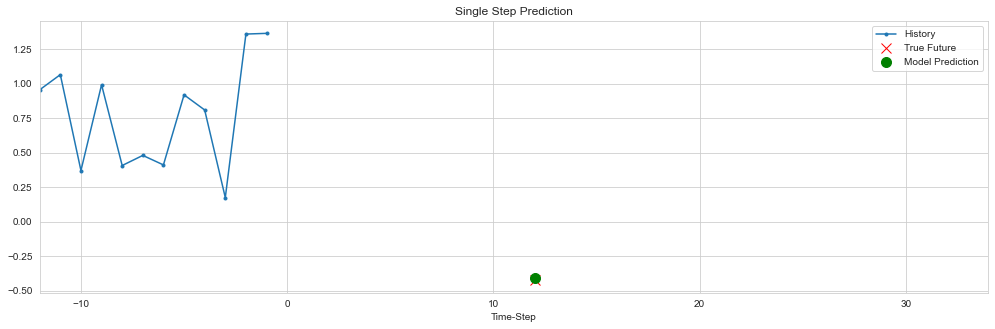

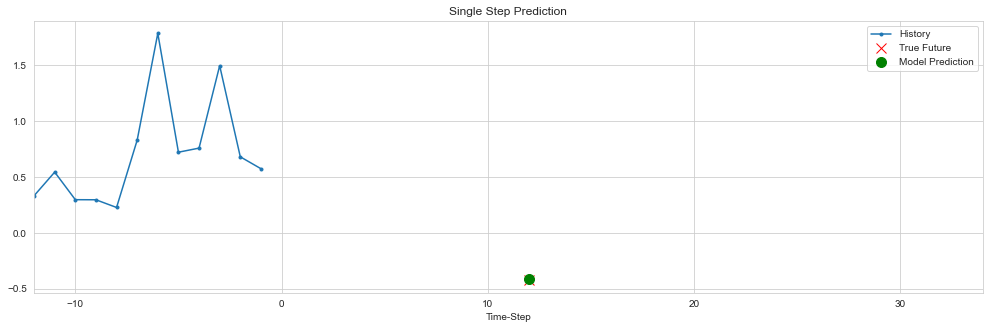

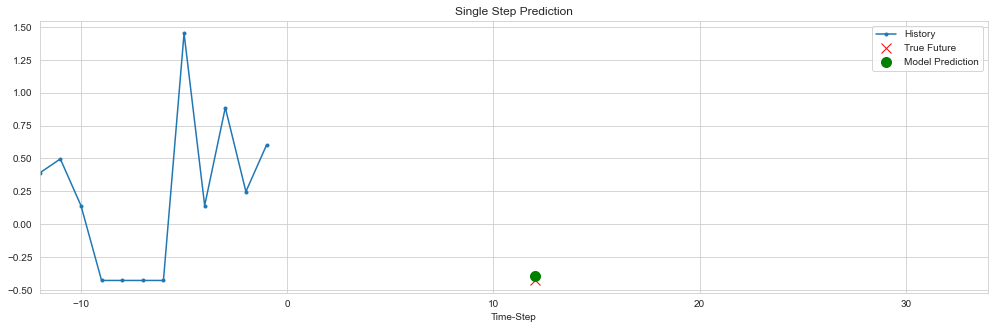

In [167]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

In [170]:
features_considered2 = features_considered

In [171]:
features = data[features_considered2]

features.index = data['date']
features.head()

,AKSH_227_wc_vol,AKSH_227_bhp_fluid_level,AKSH_227_bhp_pump_press,AKSH_240_liq_vol,AKSH_240_wc_vol,AKSH_240_bhp_fluid_level,AKSH_240_bhp_pump_press
date,,,,,,,
2017-01-01,90.021,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-02,90.014,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-03,90.004,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-04,89.975,0.0,0.0,NaN,NaN,NaN,NaN
2017-01-05,85.999,0.0,0.0,NaN,NaN,NaN,NaN


In [172]:
dataset2 = features.values

In [525]:
past_history = 70
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset2, dataset[:,:2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset2, dataset[:,:2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [526]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [527]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                           input_shape=x_train_single.shape[-2:]))

single_step_model.add(tf.keras.layers.Dense(2))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

In [528]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

In [529]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/100
200/200 [==============================] - 21s 81ms/step - loss: nan - val_loss: nan
Epoch 2/100
200/200 [==============================] - 16s 78ms/step - loss: nan - val_loss: nan
Epoch 3/100
200/200 [==============================] - 16s 79ms/step - loss: nan - val_loss: nan
Epoch 4/100
200/200 [==============================] - 16s 78ms/step - loss: nan - val_loss: nan
Epoch 5/100
200/200 [==============================] - 15s 77ms/step - loss: nan - val_loss: nan
Epoch 6/100
200/200 [==============================] - 15s 77ms/step - loss: nan - val_loss: nan
Epoch 7/100
200/200 [==============================] - 16s 78ms/step - loss: nan - val_loss: nan
Epoch 8/100
200/200 [==============================] - 16s 78ms/step - loss: nan - val_loss: nan
Epoch 9/100
200/200 [==============================] - 15s 75ms/step - loss: nan - val_loss: nan
Epoch 10/100
200/200 [==============================] - 15s 76ms/step - loss: nan - val_loss: nan
Epoch 11/100
200/200 [=======

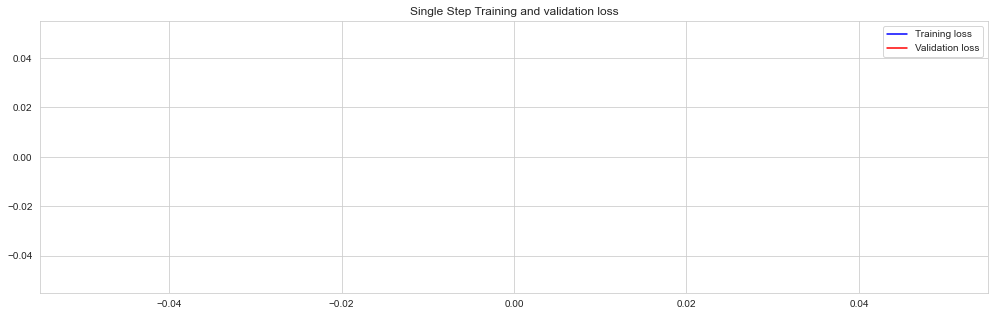

In [178]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

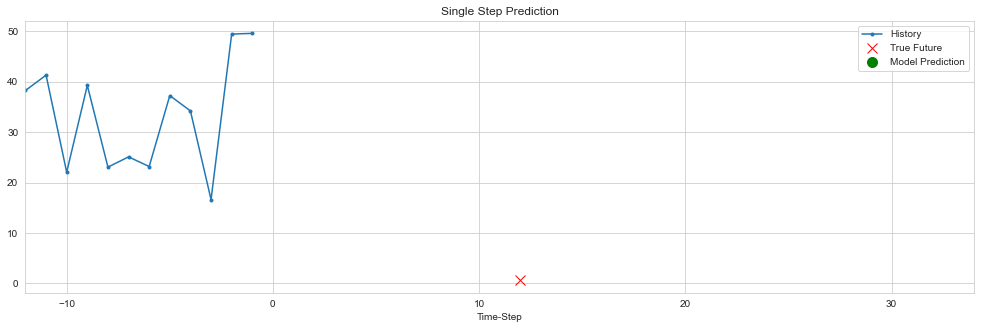

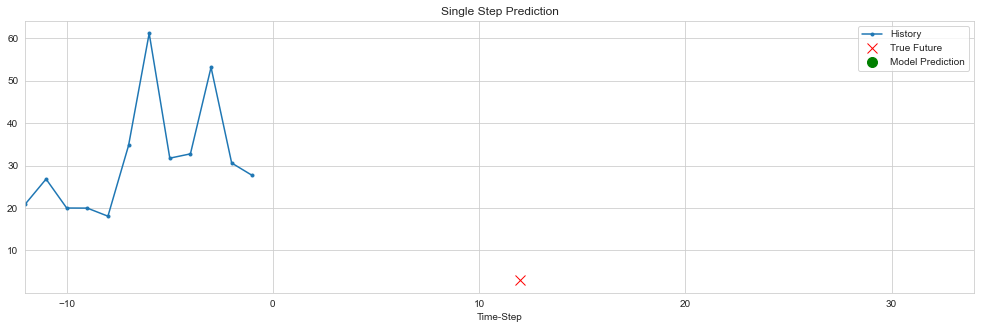

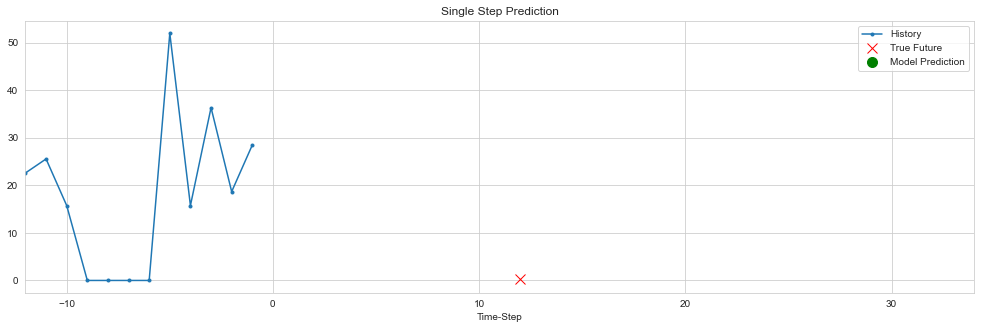

In [179]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

In [540]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [578]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size]) # рекурсивная подстановка в i в случае много шаговости

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis] # вывод метрик оси создать

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history)) # длина окана истории обучения
    num_out = len(true_future)   # длина прогнозирования
    
    for i, (var, c) in enumerate(zip(features.columns[:3], ['b','r','g'])): # задание вывода прогнозируемых параметров многопараметрического вывода
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [579]:
future_target = 72 # 72 дня
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:6], dataset[:,:6], 0, # задание данных X, y и размерности для вывода
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:6], dataset[:,:6],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [580]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(330, 12, 6, 1, 1)
(330, 72, 6, 1, 1)
(689, 12, 6, 1, 1)
(689, 72, 6, 1, 1)
Single window of past history : (12, 6, 1, 1)
Target temperature to predict : (72, 6, 1, 1)


In [581]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

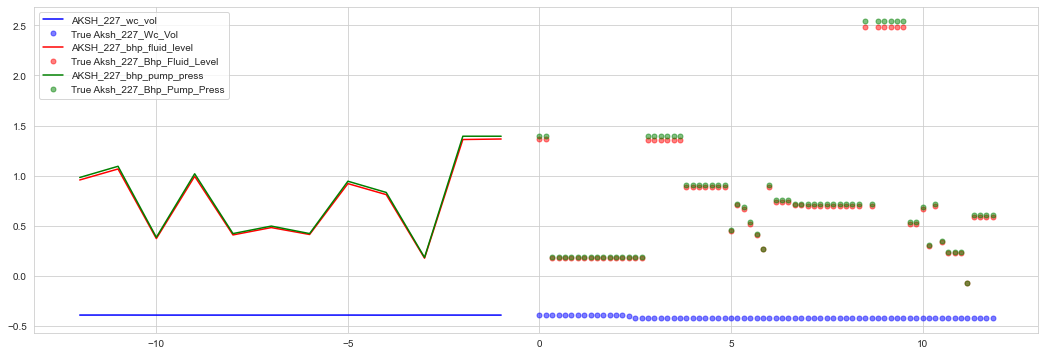

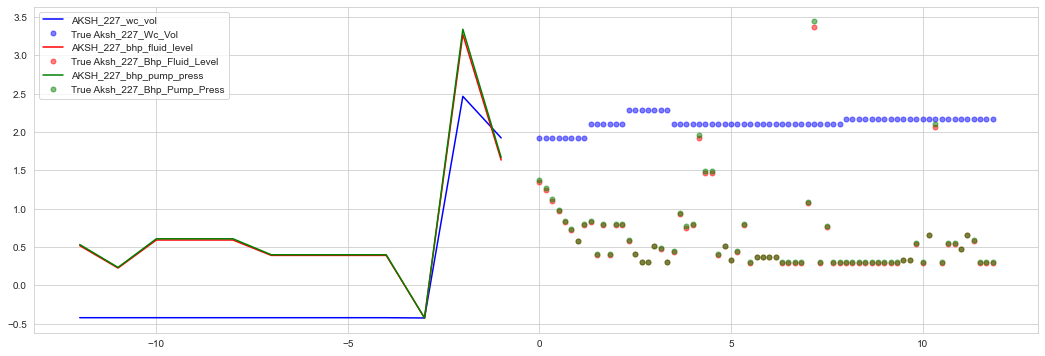

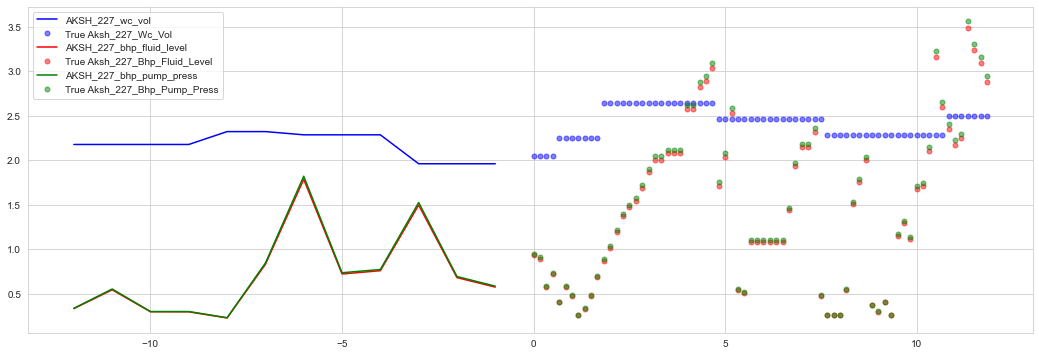

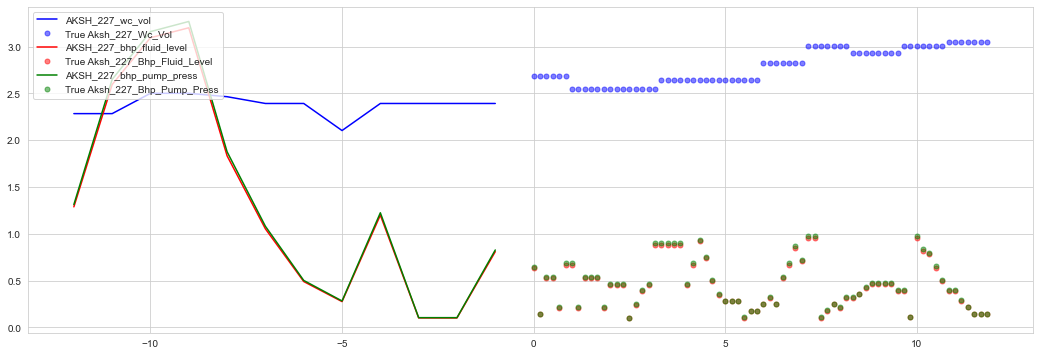

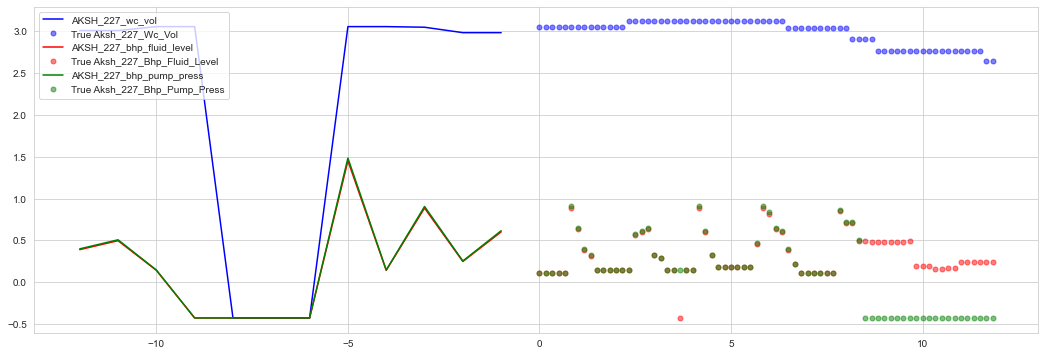

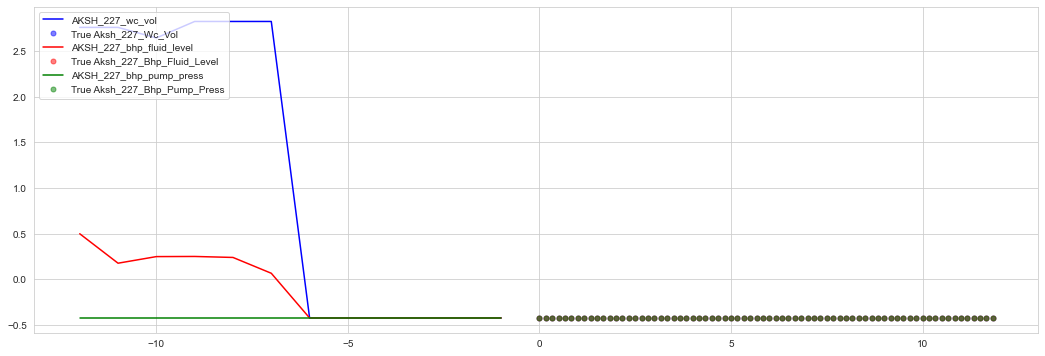

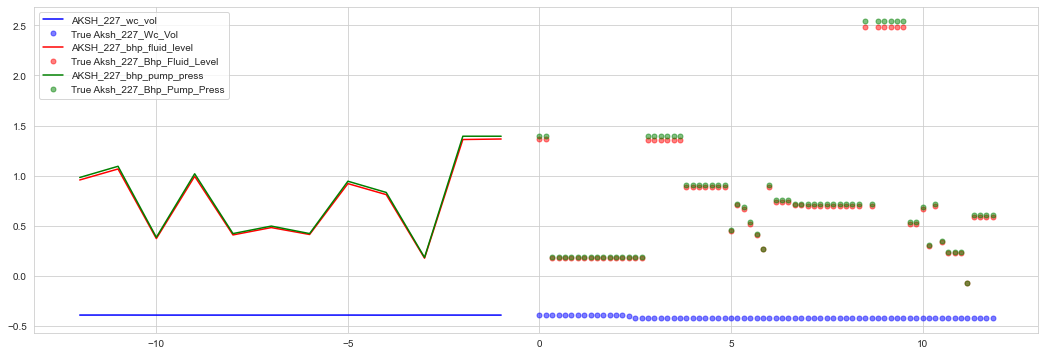

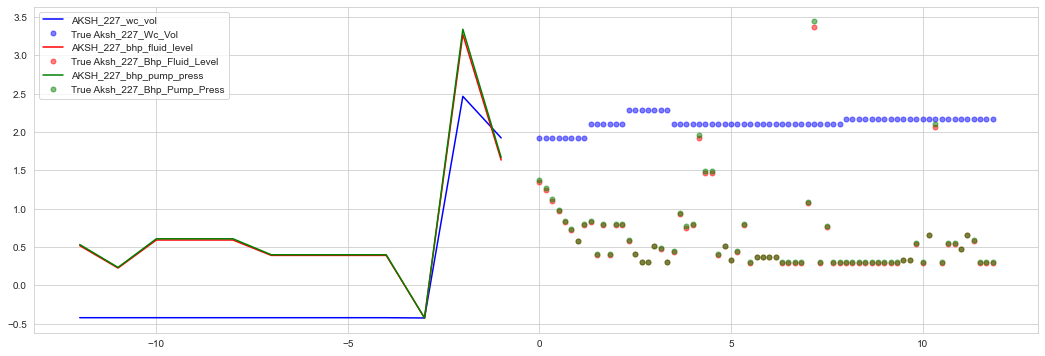

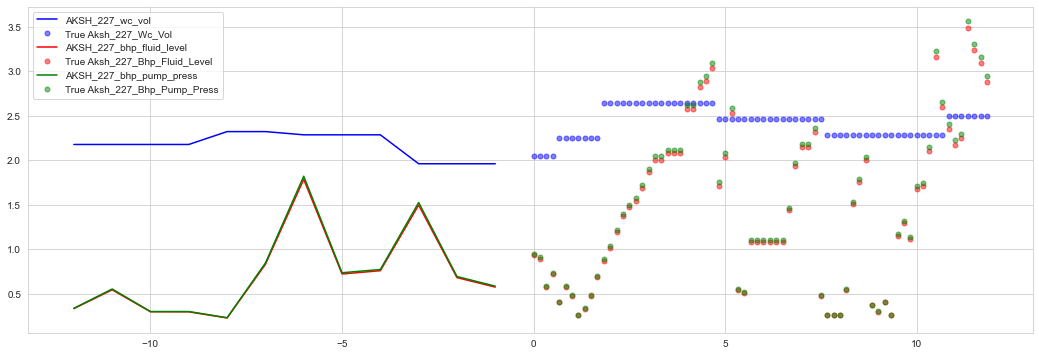

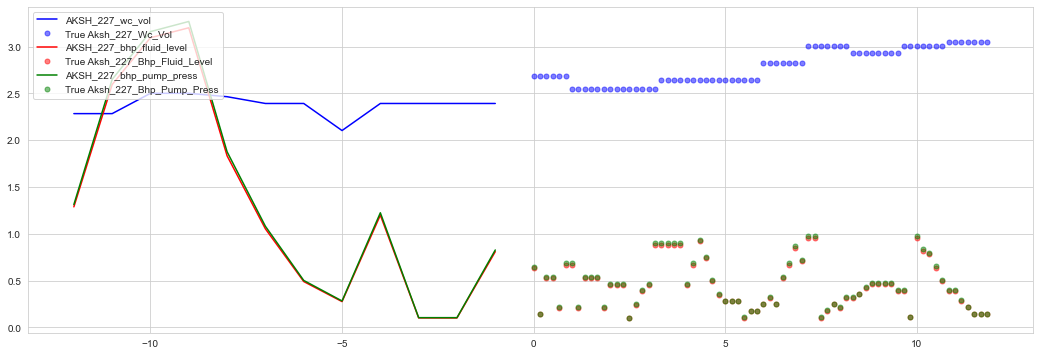

In [582]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [583]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (10, 1), # расширение сужение
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_4'))
    model.add(BatchNormalization(name = 'batch_norm_4'))
    model.add(ConvLSTM2D(name ='conv_lstm_5',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_5'))
    model.add(BatchNormalization(name = 'batch_norm_5'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_6',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [584]:
future_target = 72
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [585]:
EPOCHS = 4 #40
steps_per_epoch = 10 # 350 
validation_steps = 5 # 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 12, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 12, 2, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 2, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 12, 2, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)        

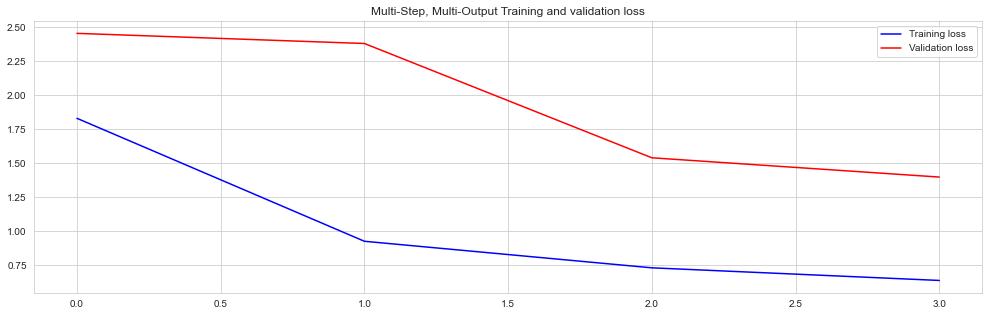

In [586]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

IndexError: index 2 is out of bounds for axis 1 with size 2

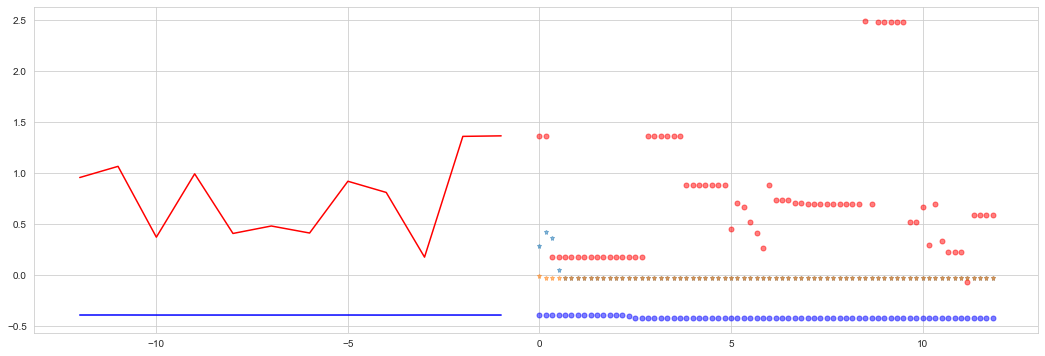

In [587]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

In [ ]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [ ]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (20, 1), 
                         padding='same',
                         return_sequences = True))
    model.add(Dropout(0.20, name = 'dropout_4'))
    model.add(BatchNormalization(name = 'batch_norm_4'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_5',
                         filters = 64, kernel_size = (20, 1), 
                         padding='same',
                         return_sequences = True))
    model.add(Dropout(0.20, name = 'dropout_5'))
    model.add(BatchNormalization(name = 'batch_norm_5'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_6',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    model.add(Dropout(0.20, name = 'dropout_6'))
    model.add(BatchNormalization(name = 'batch_norm_6'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_7',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_7'))
    model.add(BatchNormalization(name = 'batch_norm_7'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_8',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [521]:
# Окно предсказания 144 дня (шаг - 1 )
future_target = 144
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128 # Размер случайного обучающего фрейма

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [512]:
EPOCHS = 2
steps_per_epoch = 10
validation_steps = 10

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 12, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 12, 2, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 2, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 12, 2, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)        

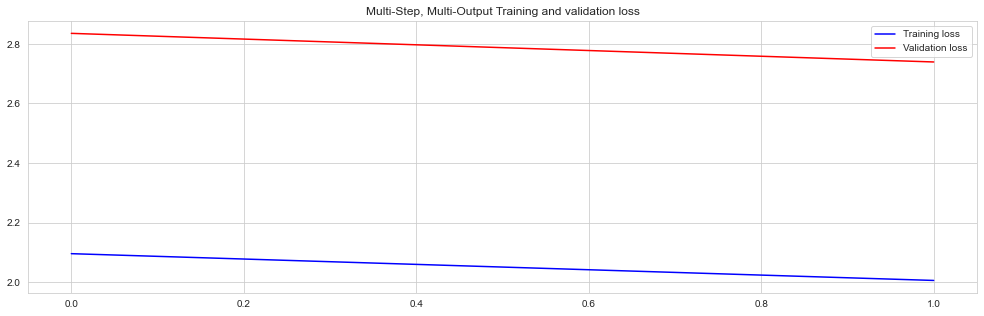

In [513]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

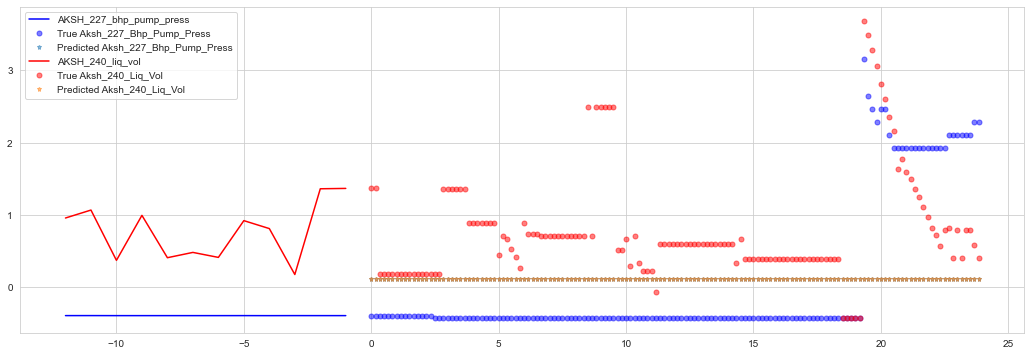

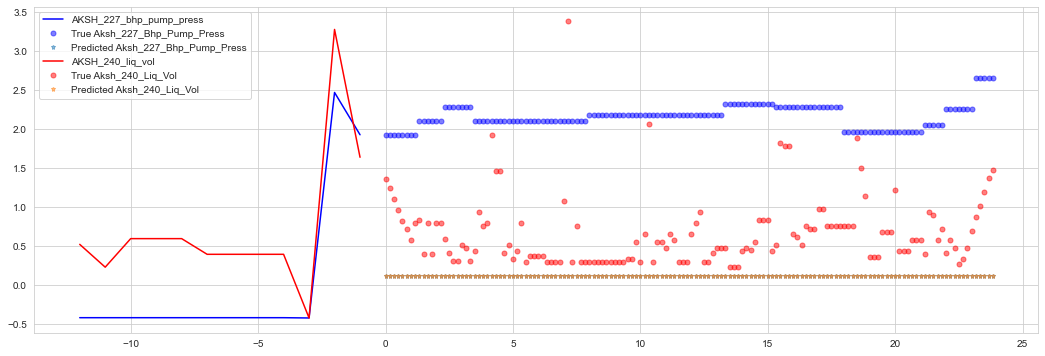

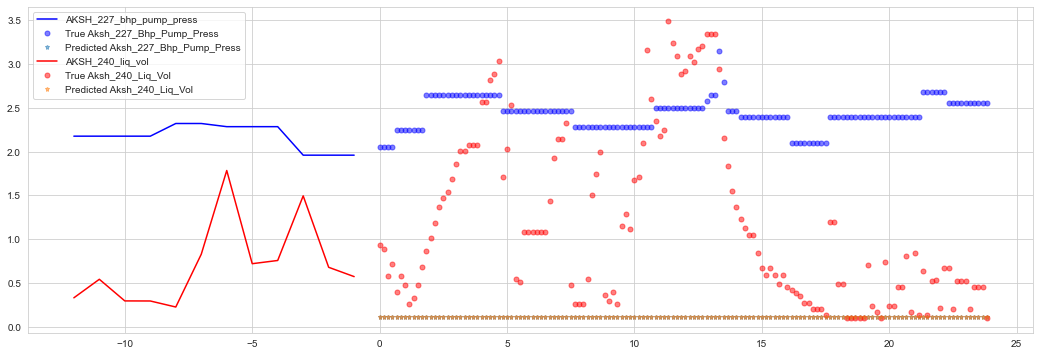

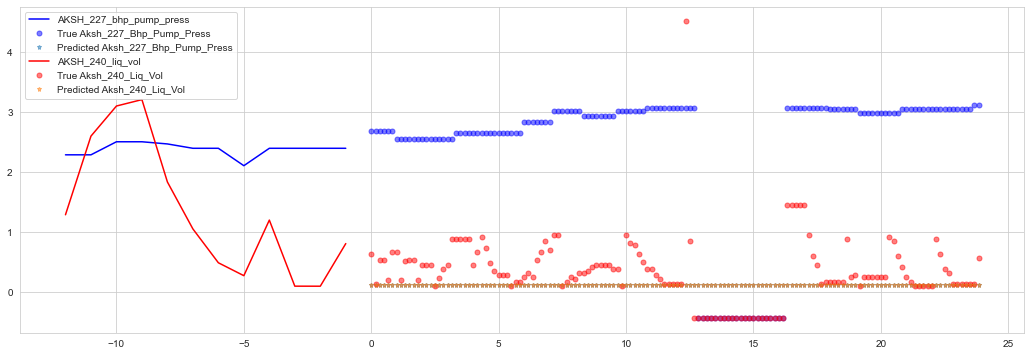

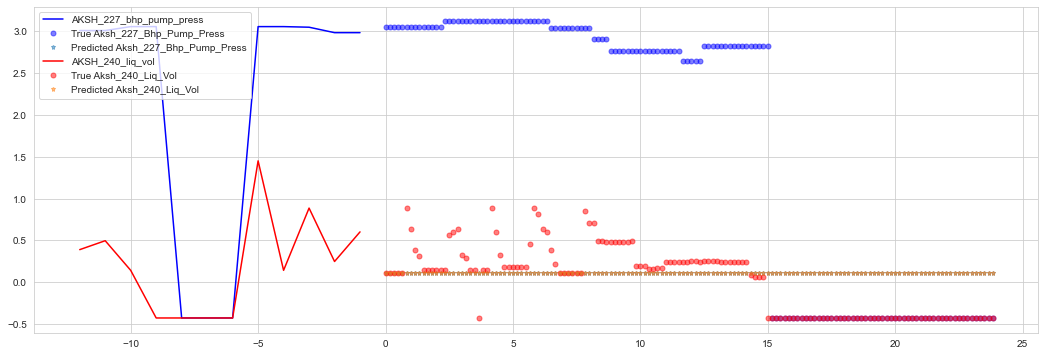

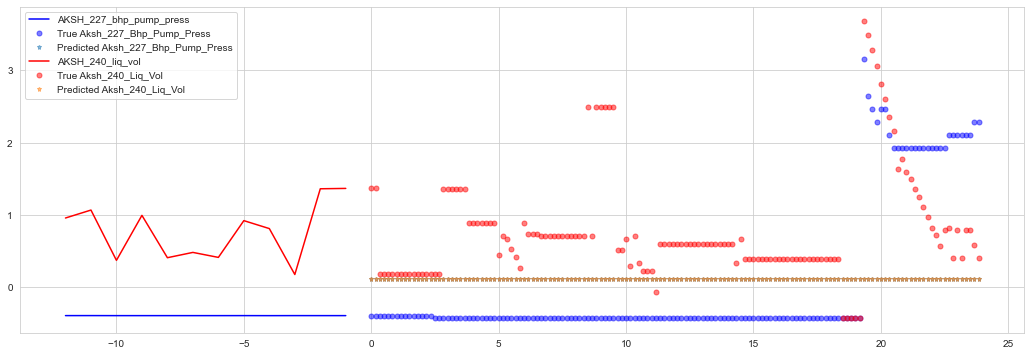

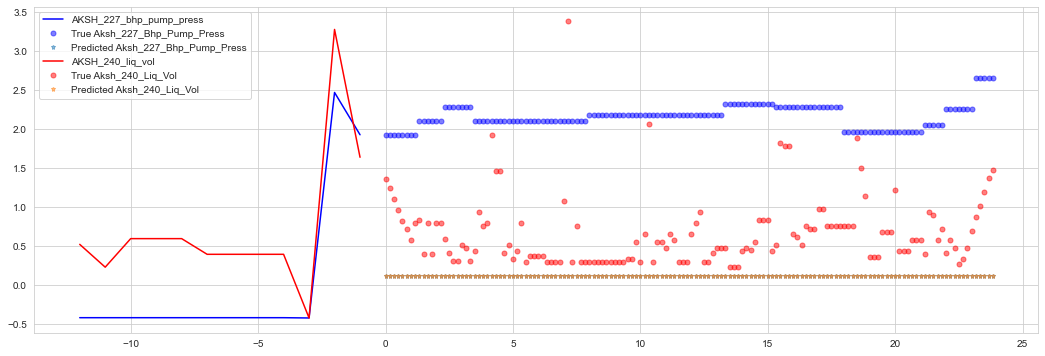

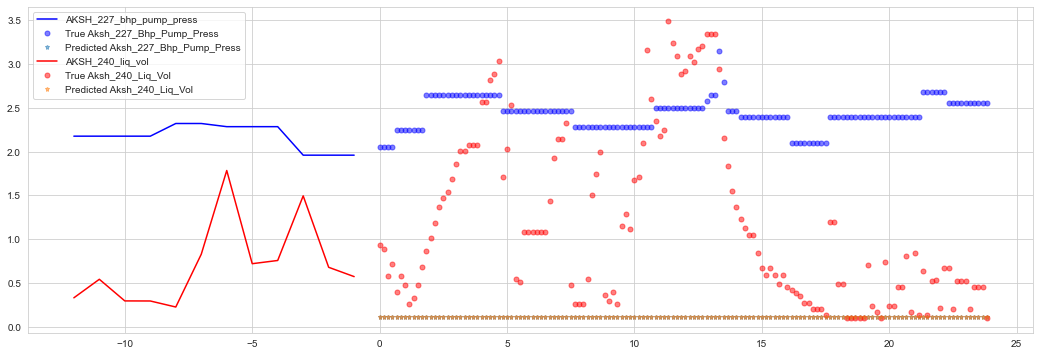

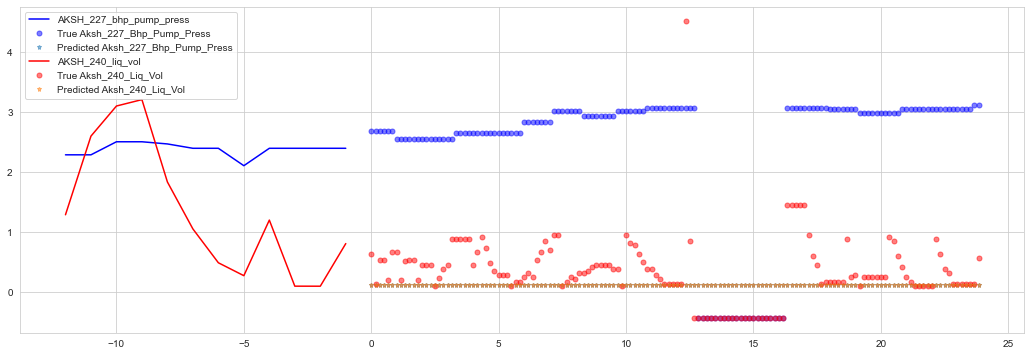

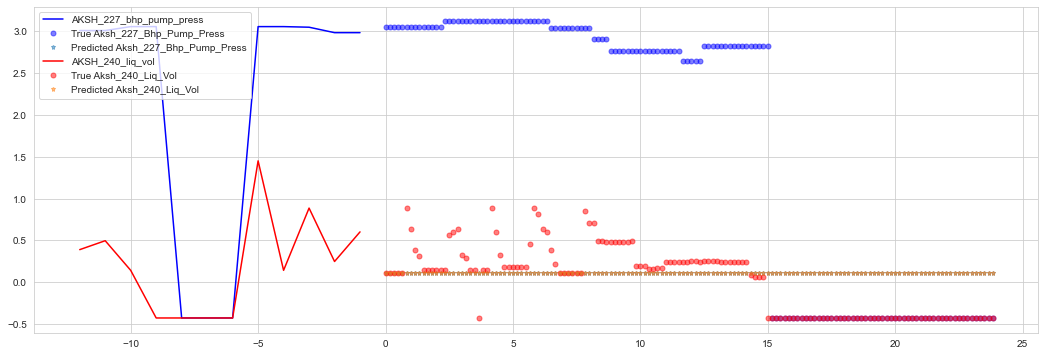

In [514]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

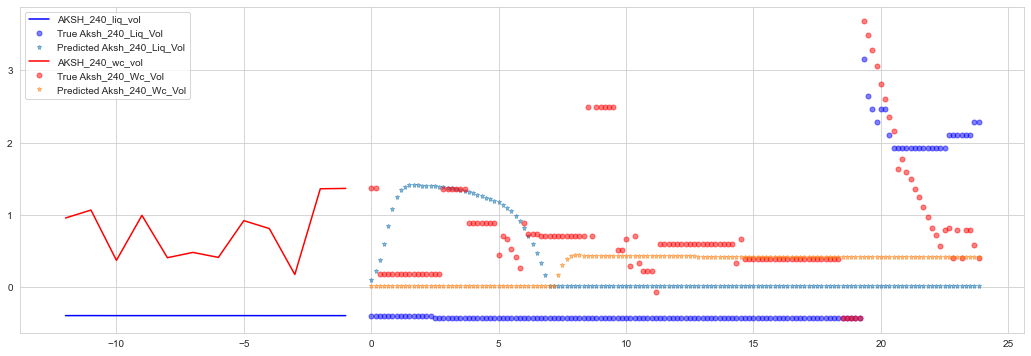

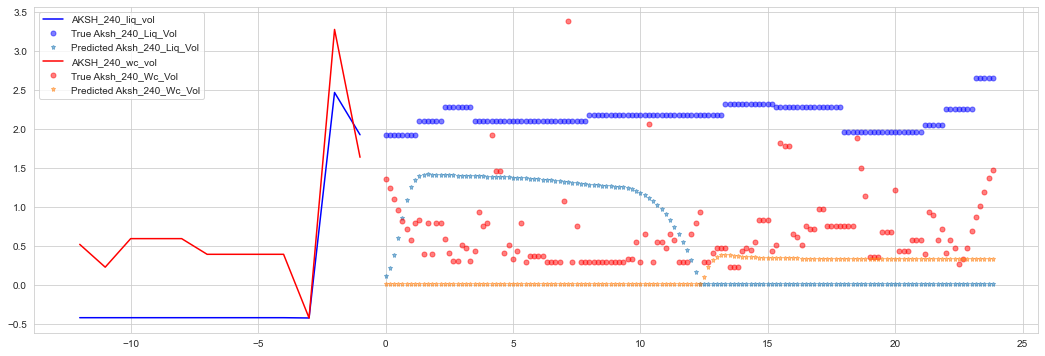

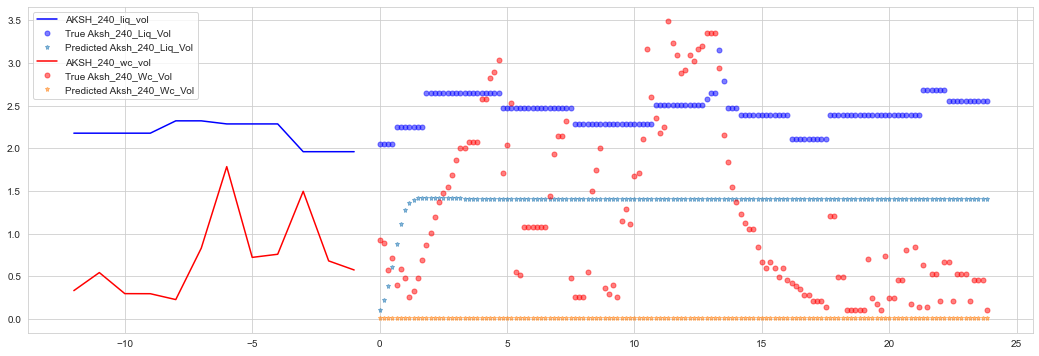

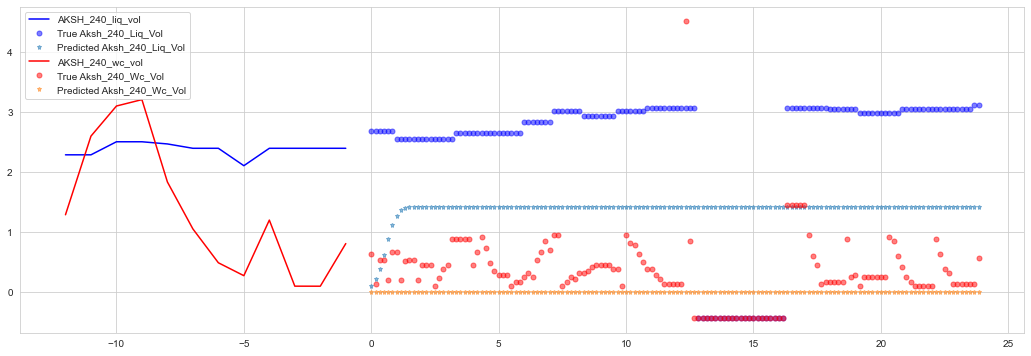

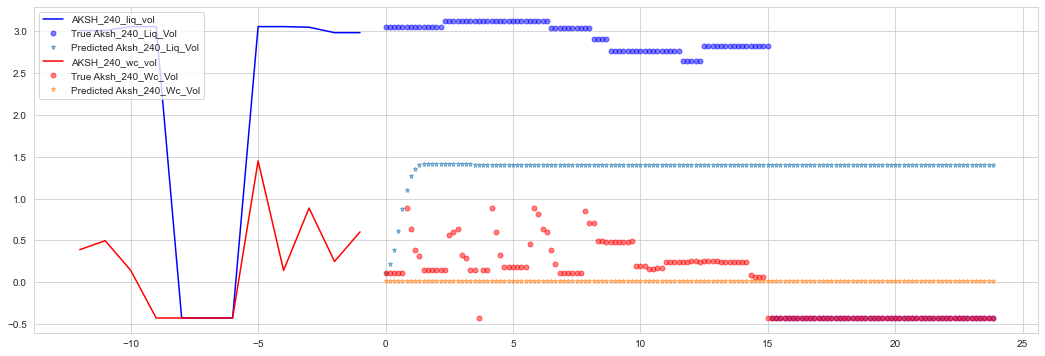

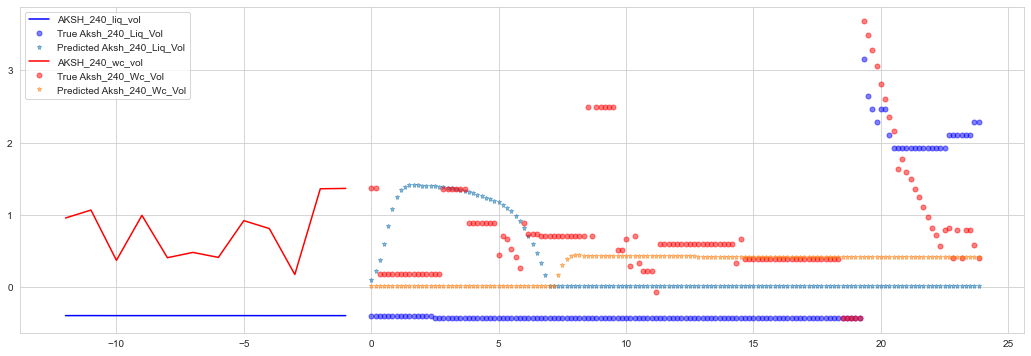

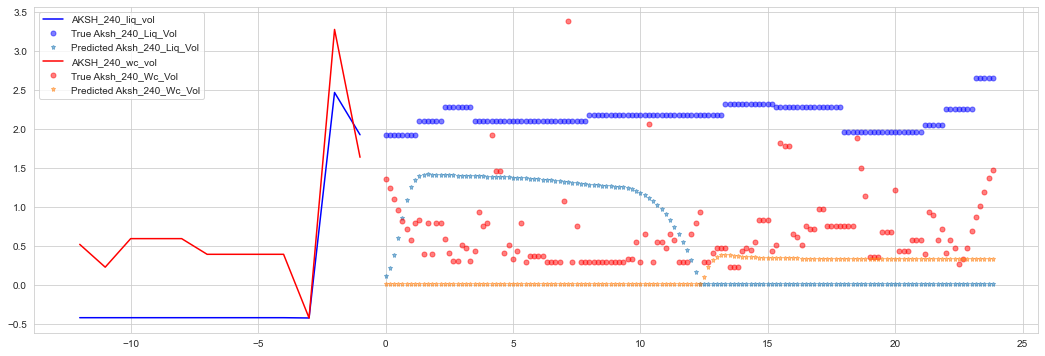

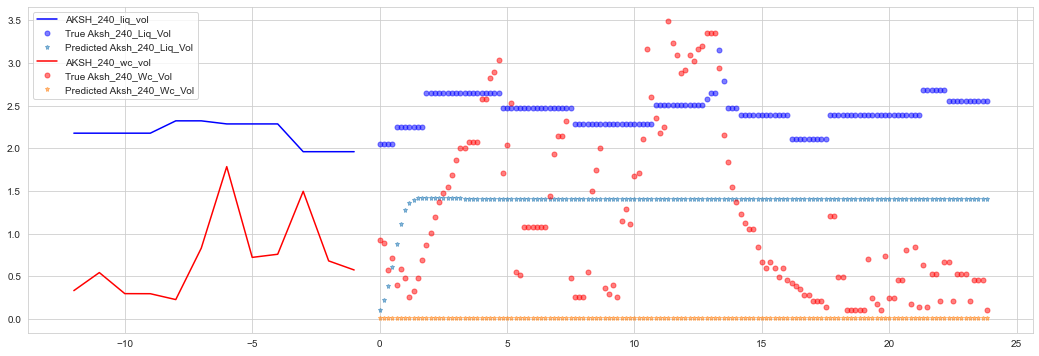

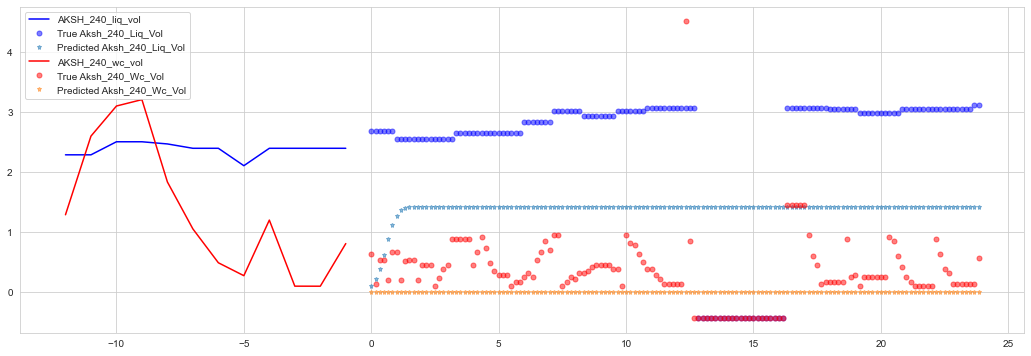

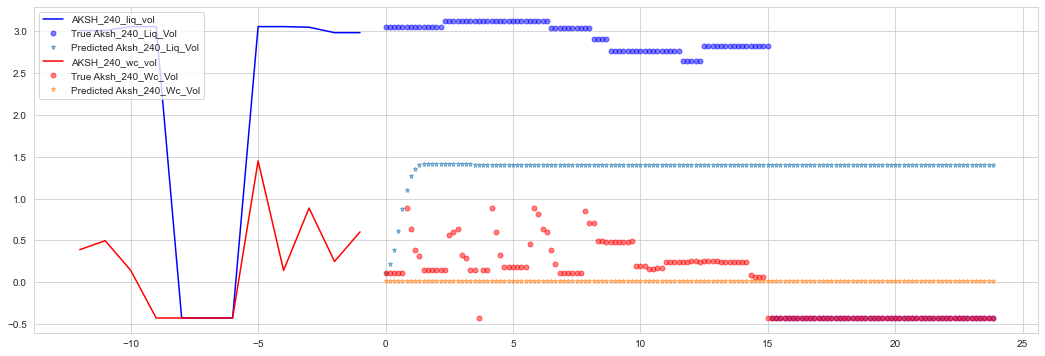

In [385]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

In [227]:
import keras

from keras.layers import merge

In [232]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    
   

   
    
    
    #model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return single_step_model

In [533]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model





In [534]:
EPOCHS = 4 #40
steps_per_epoch = 10 # 350 
validation_steps = 5 # 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = multi_step_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

ValueError: Input 0 of layer sequential_55 is incompatible with the layer: expected ndim=3, found ndim=0. Full shape received: ()

In [517]:
right = Sequential()
right.add(LSTM(64, input_shape=(80,600)))
right.add(Dense(600))

single_step_model1 = Sequential()
single_step_model1.add(Concatenate([model, right]))
single_step_model1.add(Dense(4))
single_step_model1.add(Activation('softmax'))
single_step_model1.compile(loss='categorical_crossentropy',optimizer='rmsprop')

In [518]:
X_left = dataset[:,:2]
X_right = dataset[:,:2]
Y_train= dataset[:,:2]

single_step_model1.fit([X_left, X_right],Y_train)

Consider rewriting this model with the Functional API.


TypeError: in user code:

    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1008 __call__
        self._maybe_build(inputs)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\utils\tf_utils.py:272 wrapper
        output_shape = fn(instance, input_shape)
    D:\anaconda3\lib\site-packages\tensorflow\python\keras\layers\merge.py:500 build
        del reduced_inputs_shapes[i][self.axis]

    TypeError: list indices must be integers or slices, not ListWrapper


In [ ]:
history = model.fit([x_train_multi, x_train_multi], train_y_LSTM,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])

# CNNLSTM

In [82]:
# from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [83]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [84]:
from keras.layers import Bidirectional

In [85]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.ConvLSTM2D(filters=4, kernel_size=6, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), activation='tanh',
    recurrent_activation='hard_sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True,
    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
    bias_constraint=None, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0))
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

In [141]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [142]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [151]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['liq_vol'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['liq_vol']

In [152]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [153]:
baseline = Baseline()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [154]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [155]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [156]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 2994578320.6400 - mean_absolute_error: 11102.3481WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A593638EE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export A

In [157]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/25 [====================>.........] - ETA: 0s - loss: 265704692.4444 - mean_absolute_error: 4792.4910WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A598A998B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

In [158]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [159]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [160]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [161]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

NameError: name 'wide_window' is not defined

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
OUT_STEPS = 1
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)


In [ ]:
single.step_model.add(multi_conv_model)

# 3D LSTM + 3D CNN

In [86]:
!pip install mdrnn

In [105]:
df = features

In [106]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [107]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [108]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [114]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['data'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['data']

In [118]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [119]:
w2.example = example_inputs, example_labels

NameError: name 'example_inputs' is not defined

In [116]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [117]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

NameError: name 'w2' is not defined

In [87]:
from mdrnn import MDRNN, MDLSTM, MultiDirectional
import numpy as np
import tensorflow as tf


In [102]:
import tensorflow as tf

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    if training:
      x = self.dropout(x, training=training)
    return self.dense2(x)

model = MyModel()